In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random

from collections import defaultdict
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn import metrics

from catboost import CatBoostRegressor, CatBoostClassifier, Pool

In [2]:
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score, all_nrmse

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(42) # Seed 고정

pd.set_option('display.max_columns', None)

df = pd.read_csv('train.csv')
df.drop(columns=['X_04', 'X_23', 'X_47', 'X_48'], inplace=True)

train_df, valid_df = train_test_split(df, train_size=0.8)

train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.filter(regex='Y') # Output : Y Feature

valid_x = valid_df.filter(regex='X') # Input : X Featrue
valid_y = valid_df.filter(regex='Y') # Output : Y Feature

# LR = MultiOutputRegressor(LinearRegression()).fit(train_x, train_y)

# valid_preds = LR.predict(valid_x)
# lg_nrmse(valid_y.values, valid_preds)

In [191]:
df = pd.read_csv('anomaly_detection_train.csv').drop(columns=['X_04', 'X_23', 'X_47', 'X_48'])

x = pd.concat([df.filter(regex='X'), df.Abnormal], axis=1)
y = df.filter(regex='Y')

submit = pd.read_csv('sample_submission.csv')

seed = 42
n_fold = 10

score = defaultdict(int)
kf = KFold(n_splits=n_fold)
for idx, (train, valid) in enumerate(kf.split(x), 1):
    print("Fold | ", idx)
    train_x, train_y = x.loc[train], y.loc[train]
    valid_x, valid_y = x.loc[valid], y.loc[valid]
    
    for col in valid_y.columns:
        train_data = Pool(data=train_x, label=train_y[col])
        valid_data = Pool(data=valid_x, label=valid_y[col])

        model = CatBoostRegressor(loss_function='RMSE')
        model.fit(train_data, eval_set=valid_data, use_best_model=True, silent=True)

        preds = model.predict(valid_x)
        gt = valid_y[col].values

        rmse = metrics.mean_squared_error(gt, preds, squared=False)
        nrmse = rmse/np.mean(np.abs(gt))
        score[col] += nrmse / n_fold
        
        preds = model.predict(test_x)
        submit[col] += preds / n_fold

print(score)
submit.to_csv('catboost_normal_abnormal3.csv', index=False)

Fold |  1
Fold |  2
Fold |  3
Fold |  4
Fold |  5
Fold |  6
Fold |  7
Fold |  8
Fold |  9
Fold |  10
defaultdict(<class 'int'>, {'Y_01': 0.2494904132637769, 'Y_02': 0.34888704518671915, 'Y_03': 0.3391351563178166, 'Y_04': 0.18823119502319663, 'Y_05': 0.07938927237287653, 'Y_06': 0.07816892990850703, 'Y_07': 0.12796266170799556, 'Y_08': 0.023585796362694623, 'Y_09': 0.023386657386199227, 'Y_10': 0.036626371972741434, 'Y_11': 0.032953869830655506, 'Y_12': 0.023524035889169955, 'Y_13': 0.02347231599212116, 'Y_14': 0.023513289825526654})


In [193]:
score

defaultdict(int,
            {'Y_01': 0.2494904132637769,
             'Y_02': 0.34888704518671915,
             'Y_03': 0.3391351563178166,
             'Y_04': 0.18823119502319663,
             'Y_05': 0.07938927237287653,
             'Y_06': 0.07816892990850703,
             'Y_07': 0.12796266170799556,
             'Y_08': 0.023585796362694623,
             'Y_09': 0.023386657386199227,
             'Y_10': 0.036626371972741434,
             'Y_11': 0.032953869830655506,
             'Y_12': 0.023524035889169955,
             'Y_13': 0.02347231599212116,
             'Y_14': 0.023513289825526654})

In [194]:
sum([1.2*v if k in train_y.columns[:7] else v for k, v in score.items()])

1.8805799457961745

## test_x 제작

In [214]:
df1 = pd.read_csv('normal_train.csv')
df2 = pd.read_csv('abnormal_train.csv')

test_x = pd.read_csv('test.csv').drop(columns=['ID', 'X_04', 'X_23', 'X_47', 'X_48'])
submit = pd.read_csv('sample_submission.csv')

seed = 42
n_fold = 5

print(len(df1), len(df2))

df1['Abnormal'] = 0
df2['Abnormal'] = 1

df = pd.concat([df1.iloc[:len(df2)*6], df2])

x = df.filter(regex='X')
y = df.Abnormal

test_x['Abnormal'] = 0

score = defaultdict(int)
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
valid_preds = pd.DataFrame()
test_preds = pd.DataFrame()
for train, valid in skfold.split(x, y):
    train_x, train_y = x.iloc[train], y.iloc[train]
    valid_x, valid_y = x.iloc[valid], y.iloc[valid]

    train_data = Pool(data=train_x, label=train_y)
    valid_data = Pool(data=valid_x, label=valid_y)

    model = CatBoostClassifier()
    model.fit(train_data, eval_set=valid_data, use_best_model=True, silent=True)

    pred = model.predict(valid_x)
    # print(pd.DataFrame(pred).value_counts())
    gt = valid_y.values
    # print(log_loss(gt, pred))

    pred = model.predict(test_x.drop(columns=['Abnormal']))
    test_x.Abnormal += pred
    
print(test_x.Abnormal.value_counts())
test_x.Abnormal //= 3
print(test_x.Abnormal.value_counts())

35690 3917
0    36739
5      998
1      724
4      399
2      395
3      353
Name: Abnormal, dtype: int64
0    37858
1     1750
Name: Abnormal, dtype: int64


## test_x 언제가 제일 잘만드나?

In [216]:
df1 = pd.read_csv('normal_train.csv')
df2 = pd.read_csv('abnormal_train.csv')

test_x = pd.read_csv('test.csv').drop(columns=['ID', 'X_04', 'X_23', 'X_47', 'X_48'])
submit = pd.read_csv('sample_submission.csv')

seed = 42
n_fold = 5

print(len(df1), len(df2))

df1['Abnormal'] = 0
df2['Abnormal'] = 1


for times in range(1, 10):
    result = {
        '00' : 0,
        '01' : 0,
        '10' : 0,
        '11' : 0,
             }

    df = pd.concat([df1.iloc[:len(df2)*times], df2])

    x = df.filter(regex='X')
    y = df.Abnormal

    # test_x['Abnormal'] = 0

    score = defaultdict(int)
    skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    valid_preds = pd.DataFrame()
    test_preds = pd.DataFrame()
    for train, valid in skfold.split(x, y):
        train_x, train_y = x.iloc[train], y.iloc[train]
        valid_x, valid_y = x.iloc[valid], y.iloc[valid]

        train_data = Pool(data=train_x, label=train_y)
        valid_data = Pool(data=valid_x, label=valid_y)

        model = CatBoostClassifier()
        model.fit(train_data, eval_set=valid_data, use_best_model=True, silent=True)

        pred = model.predict(valid_x)
        # print(pd.DataFrame(pred).value_counts())
        gt = valid_y.values
        # print(log_loss(gt, pred))

        # pred = model.predict(test_x.drop(columns=['Abnormal']))
        # test_x.Abnormal += pred

    for p, g in zip(pred, gt):
        result[str(p)+str(g)] += 1

    print(result)
    print(times, (result['11']) / (sum(result.values())-result['00']))

35690 3917
{'00': 703, '01': 220, '10': 80, '11': 563}
1 0.6523754345307068
{'00': 1537, '01': 311, '10': 29, '11': 473}
2 0.5817958179581796
{'00': 2334, '01': 322, '10': 16, '11': 461}
3 0.5769712140175219
{'00': 3055, '01': 554, '10': 78, '11': 230}
4 0.2668213457076566
{'00': 3880, '01': 719, '10': 37, '11': 64}
5 0.07804878048780488
{'00': 4688, '01': 743, '10': 12, '11': 40}
6 0.050314465408805034
{'00': 5477, '01': 779, '10': 6, '11': 5}
7 0.006329113924050633
{'00': 6267, '01': 783, '10': 0, '11': 0}
8 0.0
{'00': 7050, '01': 784, '10': 0, '11': 0}
9 0.0


{'00': 3916, '01': 784, '10': 1, '11': 0}

In [202]:
pred

array([0, 0, 0, ..., 0, 0, 0])

In [199]:
gt

array([0, 0, 0, ..., 1, 1, 1])

In [189]:
len(test_x)

39608

In [188]:
test_x.Abnormal.value_counts()

0    33755
5     2373
1     1269
4      790
2      759
3      662
Name: Abnormal, dtype: int64

In [190]:
test_x.Abnormal //= 3
test_x.Abnormal.value_counts()

0    35783
1     3825
Name: Abnormal, dtype: int64

In [173]:
df = pd.read_csv('anomaly_detection_train.csv').drop(columns=['X_04', 'X_23', 'X_47', 'X_48'])

x = df.filter(regex='X')
y = df.Abnormal

test_x = pd.read_csv('test.csv').drop(columns=['ID', 'X_04', 'X_23', 'X_47', 'X_48'])
test_x['Abnormal'] = 0
submit = pd.read_csv('sample_submission.csv')

seed = 42
n_fold = 5

score = defaultdict(int)
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
valid_preds = pd.DataFrame()
test_preds = pd.DataFrame()
for train, valid in skfold.split(x, y):
    train_x, train_y = x.iloc[train], y.iloc[train]
    valid_x, valid_y = x.iloc[valid], y.iloc[valid]
    
    train_data = Pool(data=train_x, label=train_y)
    valid_data = Pool(data=valid_x, label=valid_y)

    model = CatBoostClassifier()
    model.fit(train_data, eval_set=valid_data, use_best_model=True, silent=True)

    pred = model.predict(valid_x)
    print(pd.DataFrame(pred).value_counts())
    gt = valid_y.values
    print(log_loss(gt, pred))
    
    pred = model.predict(test_x.drop(columns=['Abnormal']))
    test_x.Abnormal = pred
    break

0    7922
dtype: int64
3.418126823227717


In [143]:
test_x.drop(columns=['Abnormal'])

,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,68.504,103.321,76.67,101.867,73.963,30.51,63.57,239.80,0.0,0.0,4.37,0.15,13.38,13.40,13.50,13.53,13.46,3.27,3.32,3.18,3.39,2.22,2.14,2.31,2.16,2.32,2.22,1.38,1.53,1.33,1.53,12.96,12.95,12.97,12.88,-16.17,-16.17,-16.84,21.22,21.06,21.21,21.20,0.16,1469,17227.63,138.130429,129.460682,141.506570,133.427229,129.711498,133.138096,121.859684
1,67.485,103.320,69.37,101.992,67.845,28.03,116.99,189.23,0.0,0.0,4.36,0.17,13.35,13.38,13.45,13.52,13.44,3.26,3.30,3.17,3.34,2.11,2.10,2.10,2.10,2.17,2.20,1.36,1.56,1.34,1.55,12.94,12.89,13.00,12.88,-15.35,-15.25,-16.01,21.21,20.99,21.26,21.15,0.27,1462,17134.53,136.148839,128.266277,145.911745,131.196417,132.411480,133.629025,124.178623
2,69.524,103.320,68.97,101.884,77.022,29.65,205.68,214.93,0.0,0.0,4.43,0.20,13.32,13.35,13.40,13.52,13.41,3.07,3.12,3.05,3.17,2.13,2.10,2.29,2.15,2.24,2.26,1.50,1.69,1.47,1.71,12.93,12.90,13.02,13.01,-16.27,-16.35,-16.95,21.16,21.05,21.15,21.19,0.14,1469,14860.83,120.447446,119.988804,132.099908,120.450155,130.051708,128.252972,114.475628
3,69.524,103.320,65.87,101.866,73.963,28.15,103.38,180.80,0.0,0.0,4.39,0.18,13.32,13.34,13.45,13.50,13.42,3.23,3.11,3.20,3.14,2.10,2.10,2.09,2.09,2.10,2.18,1.49,1.65,1.46,1.90,12.99,12.98,12.91,12.96,-16.06,-16.13,-16.75,21.15,21.03,21.16,21.14,0.13,1469,15252.53,133.994695,125.069180,147.507669,123.142653,125.963665,139.666592,126.589253
4,73.603,103.321,66.67,101.891,74.983,29.92,71.20,231.93,0.0,0.0,4.38,0.12,13.38,13.39,13.45,13.50,13.46,3.17,3.20,3.04,3.20,2.12,2.11,2.10,2.10,2.12,2.18,1.48,1.73,1.46,1.67,13.01,12.84,12.99,13.01,-16.06,-16.17,-16.76,21.15,21.08,21.12,21.17,0.09,1469,10752.23,137.918202,135.116192,138.600473,127.173033,137.252712,134.411335,124.020016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,68.504,103.320,63.97,103.157,68.864,29.49,116.35,284.16,0.0,0.0,4.35,0.14,13.38,13.37,13.48,13.51,13.45,3.16,3.06,3.07,3.09,2.13,2.08,2.09,2.07,2.12,2.16,1.37,1.66,1.36,1.56,12.98,13.00,12.91,12.90,-16.17,-16.26,-16.88,21.16,21.13,21.24,21.19,0.11,1469,62123.53,127.741246,126.494312,139.119905,125.271109,128.284572,140.176945,128.292843
39604,68.504,103.320,61.37,103.137,68.864,32.29,116.28,272.41,0.0,0.0,4.34,0.16,13.37,13.38,13.47,13.53,13.46,3.18,2.98,3.09,3.06,2.06,2.05,2.05,2.08,2.08,2.14,1.36,1.64,1.36,1.68,12.92,12.95,12.99,13.00,-16.11,-16.10,-16.73,21.16,21.03,21.22,21.12,0.19,1469,61844.13,127.767377,124.062809,138.238664,119.879393,127.322529,137.312047,131.570614
39605,69.524,103.320,63.67,103.149,69.884,30.00,113.05,295.54,0.0,0.0,4.38,0.16,13.36,13.36,13.46,13.52,13.44,3.18,3.02,3.09,3.07,2.11,2.13,2.06,2.11,2.12,2.18,1.40,1.62,1.35,1.72,12.99,12.88,13.01,12.85,-16.23,-16.32,-16.93,21.16,21.11,21.23,21.17,0.12,1469,60277.53,128.593640,124.774037,138.659624,123.999571,126.075542,135.656132,127.671108
39606,67.485,103.321,61.77,103.148,67.845,32.05,115.05,267.26,0.0,0.0,4.37,0.16,13.38,13.37,13.49,13.53,13.46,3.14,3.06,3.02,3.11,2.11,2.12,2.09,2.12,2.12,2.20,1.38,1.56,1.37,1.59,12.97,13.00,12.99,12.90,-15.99,-16.05,-16.67,21.18,21.10,21.21,21.19,0.11,1469,60236.73,121.110646,125.471699,134.989984,120.889578,129.296909,132.673977,131.882893


In [144]:
train_y.value_counts()

0    28552
1     3133
Name: Abnormal, dtype: int64

In [145]:
valid_y.value_counts()

0    7138
1     784
Name: Abnormal, dtype: int64

In [146]:
test_x.Abnormal.value_counts()

0    39608
Name: Abnormal, dtype: int64

In [153]:
df = pd.read_csv('anomaly_detection_train.csv').drop(columns=['X_04', 'X_23', 'X_47', 'X_48'])

In [162]:
cor = df.corr(method='pearson')
xycor = cor.filter(regex='A').filter(regex='X', axis=0)
xycor

,Abnormal
X_01,-0.017946
X_02,0.005126
X_03,-0.010918
X_05,-0.028126
X_06,-0.003501
X_07,-0.001960
X_08,-0.005730
X_09,-0.011544
X_10,0.006086
X_11,0.005178


<AxesSubplot:>

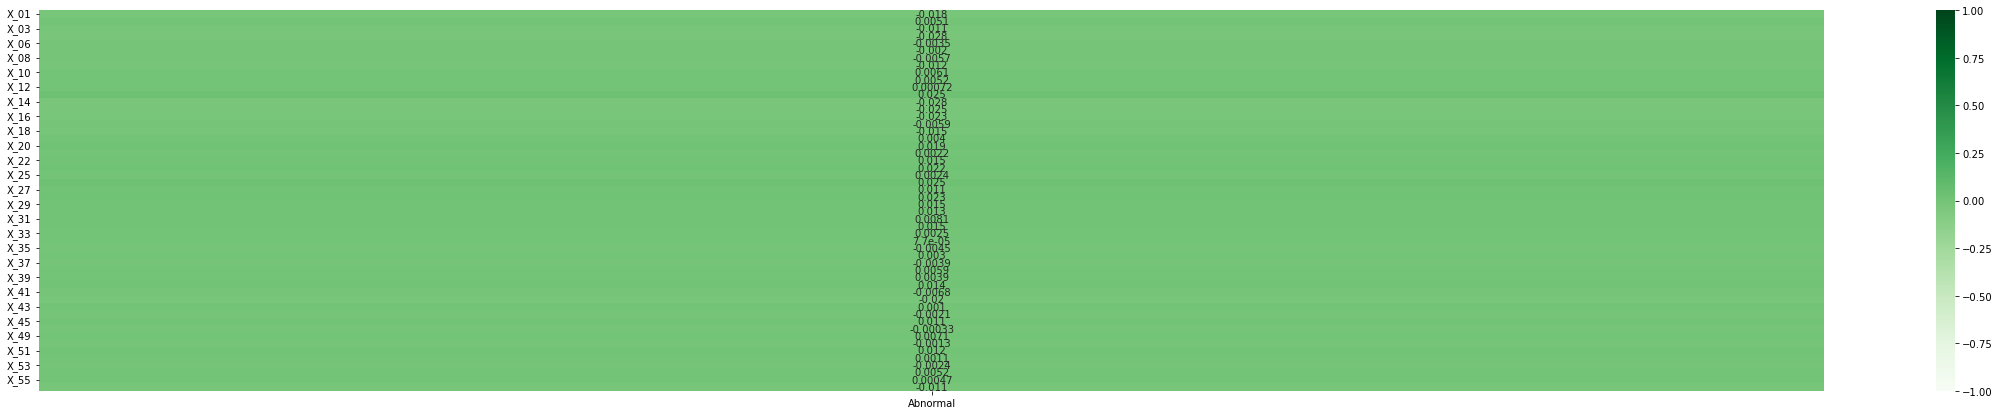

In [157]:
plt.rcParams["figure.figsize"] = (40,7)
sns.heatmap(xycor,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
          )

## one class svm

In [107]:
df = pd.read_csv('anomaly_detection_train.csv').drop(columns=['X_04', 'X_23', 'X_47', 'X_48'])

train_df, valid_df = train_test_split(df, train_size=0.9)

train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.Abnormal # Output : Y Feature

valid_x = valid_df.filter(regex='X') # Input : X Featrue
valid_y = valid_df.Abnormal # Output : Y Feature

test_x = pd.read_csv('test.csv').drop(columns=['ID']).drop(columns=['X_04', 'X_23', 'X_47', 'X_48'])

In [89]:
df.Abnormal.value_counts()

0    35690
1     3917
Name: Abnormal, dtype: int64

In [94]:
train_y.value_counts()

0    32143
1     3503
Name: Abnormal, dtype: int64

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

#Fit the model
clf = svm.OneClassSVM(nu = 0.1, kernel = "rbf", gamma = 0.00001)
clf.fit(train_x)

train_pred = clf.predict(train_x)
valid_pred = clf.predict(valid_x)


# n_error_train = y_pred_train[y_pred_train == -1].size
# n_error_test = y_pred_test[y_pred_test == -1].size

# print("n_error_train : ", n_error_train)
# print("n_error_test : ", n_error_test)

In [96]:
pd.Series(train_pred).value_counts()

 1    32080
-1     3566
dtype: int64

In [99]:
list(map(type, [train_pred, train_y]))

[numpy.ndarray, pandas.core.series.Series]

In [102]:
(train_pred == train_y.apply(lambda x: 1 if x == 0 else -1)).value_counts()

True     29301
False     6345
Name: Abnormal, dtype: int64

In [103]:
(valid_pred == valid_y.apply(lambda x: 1 if x == 0 else -1)).value_counts()

True     3171
False     790
Name: Abnormal, dtype: int64

In [108]:
test_pred = clf.predict(test_x)

In [110]:
pd.Series(test_pred).value_counts()

 1    35550
-1     4058
dtype: int64

In [164]:
test_x['Abnormal'] = list(map(lambda x: 1 if x == -1 else 0, test_pred))

In [119]:
test_x.Abnormal.value_counts()

0    35550
1     4058
Name: Abnormal, dtype: int64